# 2.1 Image processing tools

Image processing encompasses a number of techniques to improve the overall quality of an image (image smoothing, enhancement, etc.). Before going into those techniques in depth, it is useful to understand some basic concepts:

- Image histograms
- Brightness and contrast
- Binarization
- Look up tables

Next sections introduce those concepts in the context of a real problem. 

## Problem context - Number-plate recognition

<img src="./images/access_system.png" width="400">


Recently, the University of Málaga (UMA) is having trouble with private parking access. Someone has hacked their access system, so cars without previous authorization are parking there.

UMA asked computer vision students for help to implement some more secure methods that have to be included in a new security system.

They provided some images of unauthorized plates to ease the software development: `car_plate_1.jpg`, `car_plate_2.jpg` and `car_plate_3.jpg`.

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interact, fixed, widgets
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

images_path = './images/'

### Image histograms

And there we go! We are excited with the idea of developing a software to help UMA. For that, they provided us with a list of concepts and techniques that we have to master in order to design a successful plate recognition system. 

The first one is such of **histogram**:

- A representation of the frequency of each color intensity appearing in the image.
- It is built by iterating over all the pixels in the image while counting the occurrence of each color. *Note that a RGB image has 3 histograms, one per channel.* 
- It provides statistical information of the intensity distribution, like the image brightness or contrast. 

The concepts of **brightness** and **contrast** are specially relevant for image processing:
- *brightness*: average intensity of image pixels, so dark images have a low brightness, while lighter ones have a high brightness. 
- *contrast*: square distance of the intensities from the average, that is, a measure of the quality of the image given its usage of all the possible color intensities in the histogram. 

Typically, a high quality image have a medium brightness and a high contrast. 

The following code illustrates these first concepts with a few examples!

*Interesting functions: [numpy.ravel](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html)*

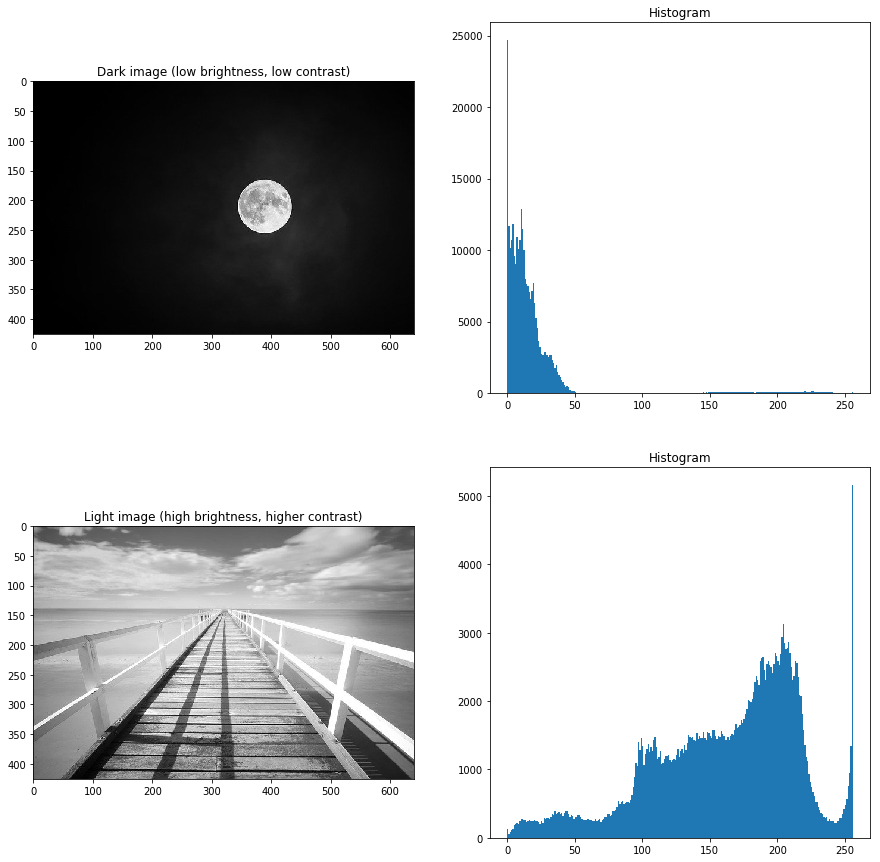

In [7]:
# Read dark image and show it
image = cv2.imread(images_path + 'landscape_1.jpg',cv2.IMREAD_GRAYSCALE)
plt.subplot(2,2,1)
plt.title("Dark image (low brightness, low contrast)")
plt.imshow(image, cmap='gray')

# Now, show its histogram
plt.subplot(2,2,2)
plt.title("Histogram")
plt.hist(image.ravel(),256,[0,256]) # ravel() returns a 1-D array, containing the elements of image

# Read light image and show it
image = cv2.imread(images_path + 'landscape_2.jpg',cv2.IMREAD_GRAYSCALE)
plt.subplot(2,2,3)
plt.title("Light image (high brightness, higher contrast)")
plt.imshow(image, cmap='gray')

# Now, its histogram
plt.subplot(2,2,4)
plt.title("Histogram")
plt.hist(image.ravel(),256,[0,256]) # ravel() returns a 1-D array, containing the elements of image
plt.show() 

### Binarization 

One of the utilities of histograms is the fit of thresholds for **binarization**. Binarization consists of assigning the "0" or black value to the pixels having and intensity value under a given threshold (`th`), and "1" or white value to those having and intensity over it. Formally:

$$
binarized(i,j)=\left\{\begin{matrix}
0 & \text{if } intenisty(i,j) < th\\ 
1 & \text{otherwise}
\end{matrix}\right. \ \ \ \forall i \in [0 \dots n\_rows], j \in [0 \dots n\_cols]
$$ 

In our context, binarization can be a great tool for separating characters appearing on the plate (with a dark color) from the rest of the plate (with a lighter one). This will remove unnecessary information within the image. So let's implement it!

**What to do?** Read the image `car_plate_1.jpg` and crop it to a rectangle containing the plate.

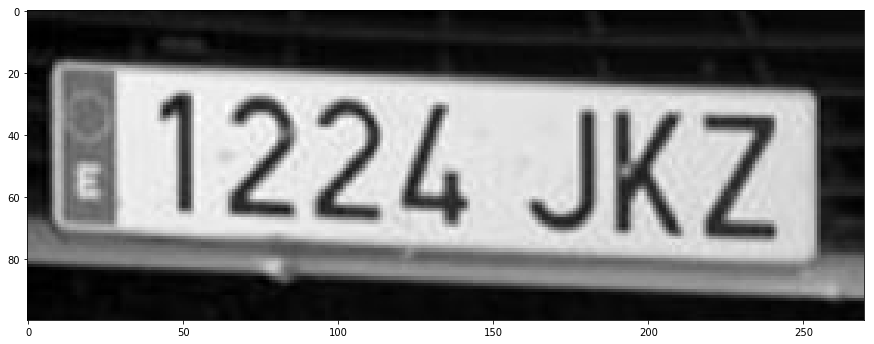

In [8]:
# Load the image
image = cv2.imread(images_path + 'car_plate_1.jpg',0)
image = image[300:400,200:470] # crop it
plt.imshow(image, cmap='gray') # show it!
plt.show()

Now, we are going to use the first concept we learned, histograms, to see if the image is easily binarizable, i.e. if the intensity of the pixels in the image are roughly grouped around two different values. 

**What to do?** Show the histogram of `image`.
*Tip: [plot histogram using matplotlib](https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.pyplot.hist.html), bins and range parameters are very important!*

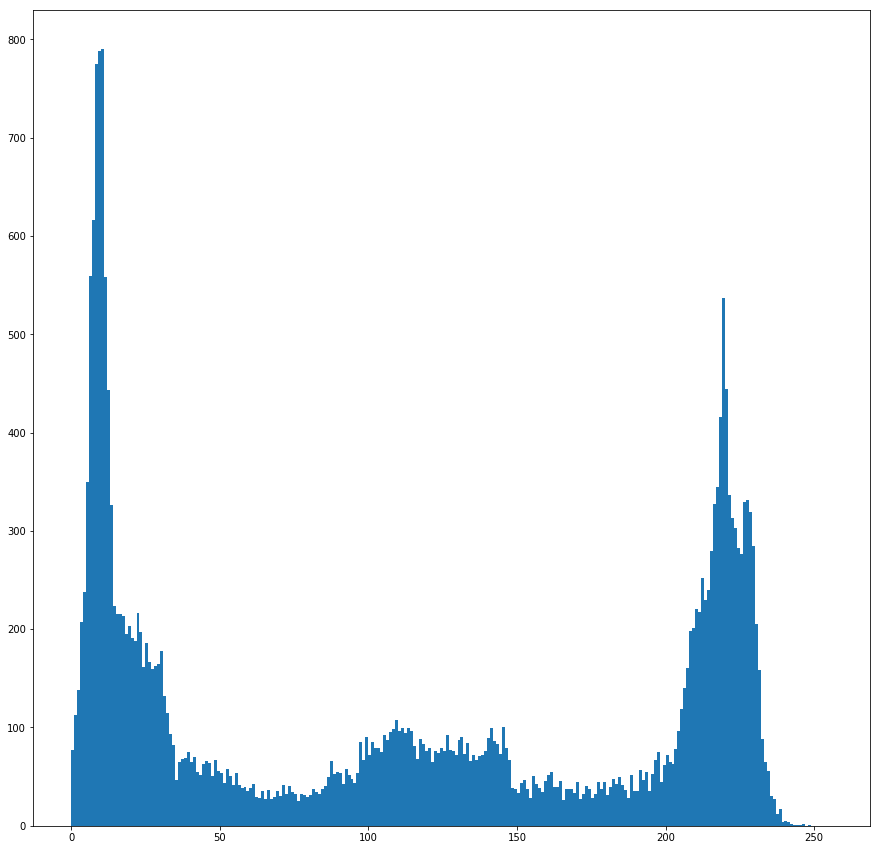

In [9]:
# Compute the histogram and show it
plt.hist(image.ravel(),256,[0,256])
plt.show()

- According to your (growing) expertise, could we correctly binarize this image? 
- Which threshold should we use?

Now that we have some cues about how to binarize an image, let's take a look through [OpenCV documentation](https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html) to develop it. 

**What to do?** Implement a function that:
- takes a gray image and a threshold as inputs, 
- binarizes the image,
- and displays it!

In [10]:
 def binarize(image,threshold):
    """ Binarizes an input image and returns it.   
    
        Args:
            image: Input image to be binarized
            threshold: Pixels with intensity values under this parameters
                    are set to 0 (black), and those over it to 255 (white).  
                    
        Returns: 
            binarized: Binarized image
    """   
    ret,binarized = cv2.threshold(image,threshold,255,cv2.THRESH_BINARY)
    plt.imshow(binarized, cmap='gray')
    plt.title('Binarized image')
    plt.show()
    
    return binarized

#### Extra! interacting with code

Jupyter has some interesting methods that allow interaction with our code, and we are going to leverage them throughout the course. Concretely, we will use the [interaction function](https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html). 

To play a bit with it, move the slider below to change the threshold value when calling the `binarize()` function. 

In [11]:
interact(binarize, image=fixed(image), threshold=(0, 255, 25))

interactive(children=(IntSlider(value=125, description='threshold', max=255, step=25), Output()), _dom_classes…

<function __main__.binarize>

### Look-up Tables (LUTs) 

Another basic, widely used technique for image processing is such of Look-up Tables (LUTs). A LUT is:

> A table to look up the output intensity for each input one. That is, it defines a mapping between input intensity values and output ones.

Note that if working with color (e.g. RGB) images, a LUT has to be defined for each color channel. 

LUTs are extremely useful for modifying the brightness and contrast of images, that is, for adapting their histograms according to our needs.

<img src="./images/bright_contrast.png" width="1000"/> 

For example, the figure below shows the result of applying a LUT where the pixels with intensities from 0 to 50 are assigned to 0 (black), and those from 200 to 255 are assigned to 255 (white). Pixels with values in between are assigned to values from 1 to 254.

<img src="./images/result_lut.png" width="500"/> 

Regarding our plate recognition problem, by doing these we remove noisy intensity values around black and white, obtaining a more *clean* image (see the resultant histogram). And, of course, we want to try it!

**How to achieve it?** Implement the `lut_chart()` function to:
- take a gray image and a look-up table (256-length array), 
- display a chart showing differences between the initial image and the resultant one after applying the LUT. *Tip: [how to create subplots in Python](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplot.html)*

*Interesting functions: [cv2.LUT](https://docs.opencv.org/master/d2/de8/group__core__array.html#gab55b8d062b7f5587720ede032d34156f)*  


In [12]:
def lut_chart(image, lut):
    """ Applies a LUT to an image and shows the result. 
    
        Args:
            image: Input image to be modified.
            lut: a 256 elements array representing a LUT, where 
                indices index input values, and their content the
                output ones.        
    """   
    # Apply LUT
    out_image = cv2.LUT(image,lut)
    
    # Show the initial image
    plt.figure(1)
    plt.subplot(2,2,1)
    plt.imshow(image, cmap='gray')
    plt.title('Original image')
    
    # Show the resultant one
    plt.subplot(2,2,2)
    plt.imshow(out_image, cmap='gray')
    plt.title('LUT applied')
    
    # Plot the used LUT
    plt.subplot(2,2,3)
    plt.title('LUT')
    plt.plot(np.arange(256),lut)

    # And finally, the resultant histogram
    plt.subplot(2,2,4)
    plt.hist(out_image.ravel(),256,[0,256])
    plt.title('Histogram')
    plt.show()


Finally, let's try our `lut_chart()` function with different look-up tables. Try to play with bright and contrast in order to get an enhanced image. **For that**:
- Create a look-up table.
- Call our function with it as second argument.

*Interesting functions: [numpy.arange](https://docs.scipy.org/doc/numpy/reference/generated/numpy.arange.html), [numpy.clip](https://docs.scipy.org/doc/numpy/reference/generated/numpy.clip.html)*

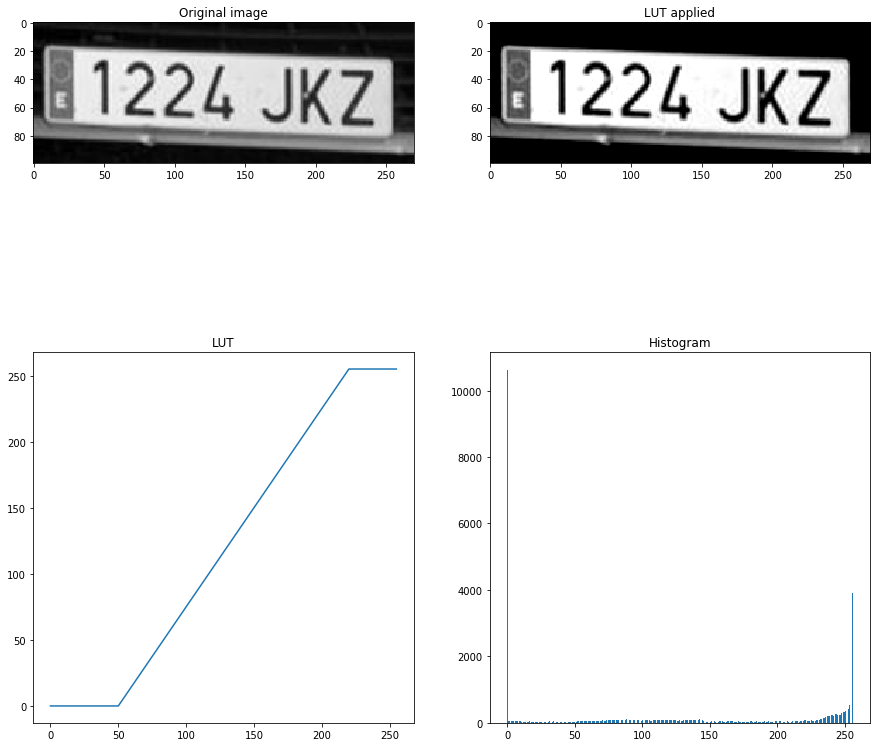

In [24]:
# Create the LUT
lut = np.arange(256)
lut = np.clip((lut-50)*1.5,0,255)
#lut = np.random.permutation(lut)
#lut = np.flip(lut)

# Execute our created function
lut_chart(image,lut)

## Conclusion

Brilliant! We've:
- learned basic concepts within image processing like histograms, brightness, contrast, binarization and Look-up Tables. 
- played a bit with them in the context of a plate recognition system, observing their utility for improving the quality of an image according to our needs. 